# The project (Fruits and Vegetables Recognition System)

##### The Libarars

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import random
import warnings
import tensorflow as tf
from tqdm import tqdm

warnings.filterwarnings("ignore")

###### Set random values for stability

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### 1. Data process

In [7]:
def load_data_from_folders(train_path, test_path, image_size=(100, 100), max_images_per_class=None):
    X_train, y_train, X_test, y_test = [], [], [], []

    for path, X, y, mode in [(train_path, X_train, y_train, "train"), (test_path, X_test, y_test, "test")]:
        classes = sorted(os.listdir(path))
        for fruit_class in tqdm(classes, desc=f"Loading {mode} classes"):
            class_path = os.path.join(path, fruit_class)
            if not os.path.isdir(class_path): continue
            images = os.listdir(class_path)
            if max_images_per_class:
                images = images[:max_images_per_class]

            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img)
                    X.append(img_array)
                    y.append(fruit_class)
                except:
                    continue

    X_train = np.array(X_train, dtype="float32") / 255.0
    X_test = np.array(X_test, dtype="float32") / 255.0

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    return X_train, y_train_encoded, X_test, y_test_encoded, le


###### paths to train and test file

In [9]:
train_path =r"C:\Users\Moham\Graduation Project\New\Training"
test_path =r"C:\Users\Moham\Graduation Project\New\Test"

In [10]:
# Download data
X_train, y_train, X_test, y_test, label_encoder = load_data_from_folders(train_path, test_path, max_images_per_class=200)

print("✅ عدد صور التدريب:", X_train.shape)
print("✅ عدد صور الاختبار:", X_test.shape)
print("✅ عدد الفئات:", len(set(y_train)))

Loading test classes: 100%|████████████████████████████████████████████████████████████| 23/23 [00:10<00:00,  2.22it/s]


✅ عدد صور التدريب: (4188, 100, 100, 3)
✅ عدد صور الاختبار: (3014, 100, 100, 3)
✅ عدد الفئات: 23


##### 2. Feature Extraction Using DenseNet121

In [12]:
features_train_file = 'features_train.npy'
features_test_file = 'features_test.npy'

if os.path.exists(features_train_file) and os.path.exists(features_test_file):
    print("Loading properties from files...")
    features_train = np.load(features_train_file)
    features_test = np.load(features_test_file)
else:
    print("Extract features using DenseNet121...")
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')
    model = Model(inputs=base_model.input, outputs=base_model.output)

    def extract_features_batch(X, batch_size=32):
        features = []
        for i in tqdm(range(0, len(X), batch_size), desc="Extracting features"):
            batch = X[i:i+batch_size]
            batch = preprocess_input(batch)
            feats = model.predict(batch, verbose=0)
            features.extend(feats)
        return np.array(features)

    features_train = extract_features_batch(X_train)
    features_test = extract_features_batch(X_test)

    np.save(features_train_file, features_train)
    np.save(features_test_file, features_test)

print("✅ Shape properties:", features_train.shape)


Loading properties from files...
✅ Shape properties: (4188, 1024)


##### 3. Feature Selection Using APGWO

In [14]:
selected_indices_file = 'selected_indices.npy'

if os.path.exists(selected_indices_file):
    print(" Download selected indexes from the file... 📥")
    selected_indices = np.load(selected_indices_file)
else:
    print("Running the APGWO algorithm for feature selection... ⚙️")

    def apgwo_feature_selection(X, y, num_wolves=30, max_iter=50, num_features_to_select=200): 
        num_features = X.shape[1]
        wolves = [np.random.choice(range(num_features), num_features_to_select, replace=False) for _ in range(num_wolves)]
        alpha, beta, delta = None, None, None
        alpha_score = beta_score = delta_score = 0

        def fitness(indices):
            X_new = X[:, indices]
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            scores = []
            for train_idx, test_idx in skf.split(X_new, y):
                X_train_fs, X_test_fs = X_new[train_idx], X_new[test_idx]
                y_train_fs, y_test_fs = y[train_idx], y[test_idx]
                clf = SVC(kernel='rbf')
                clf.fit(X_train_fs, y_train_fs)
                scores.append(accuracy_score(y_test_fs, clf.predict(X_test_fs)))
            return np.mean(scores)

        for iteration in range(max_iter):
            for wolf in wolves:
                acc = fitness(wolf)
                if acc > alpha_score:
                    alpha, alpha_score = wolf, acc
                elif acc > beta_score:
                    beta, beta_score = wolf, acc
                elif acc > delta_score:
                    delta, delta_score = wolf, acc

            new_wolves = []
            for wolf in wolves:
                new_wolf = []
                for i in range(num_features_to_select):
                    a = 2 - iteration * (2 / max_iter)
                    r1, r2 = random.random(), random.random()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    D_alpha = abs(C * alpha[i % len(alpha)] - wolf[i % len(wolf)])
                    X1 = alpha[i % len(alpha)] - A * D_alpha
                    new_idx = int(np.clip(X1, 0, num_features - 1))
                    new_wolf.append(new_idx)

                unique_indices = np.unique(new_wolf)
                while len(unique_indices) < num_features_to_select:
                    extra = np.random.choice(range(num_features), num_features_to_select - len(unique_indices), replace=False)
                    unique_indices = np.unique(np.concatenate((unique_indices, extra)))

                new_wolves.append(unique_indices)
            wolves = new_wolves

        return alpha

    selected_indices = apgwo_feature_selection(
        features_train,
        y_train,
        num_wolves=30,
        max_iter=50,
        num_features_to_select=200
    )

    np.save(selected_indices_file, selected_indices)

# Choose properties
X_train_selected = features_train[:, selected_indices]
X_test_selected = features_test[:, selected_indices]

Running the APGWO algorithm for feature selection... ⚙️


##### 4. Classifier Training and Performance Evaluation


🚀 Model training SVM
✅ Precision using SVM: 76.71%


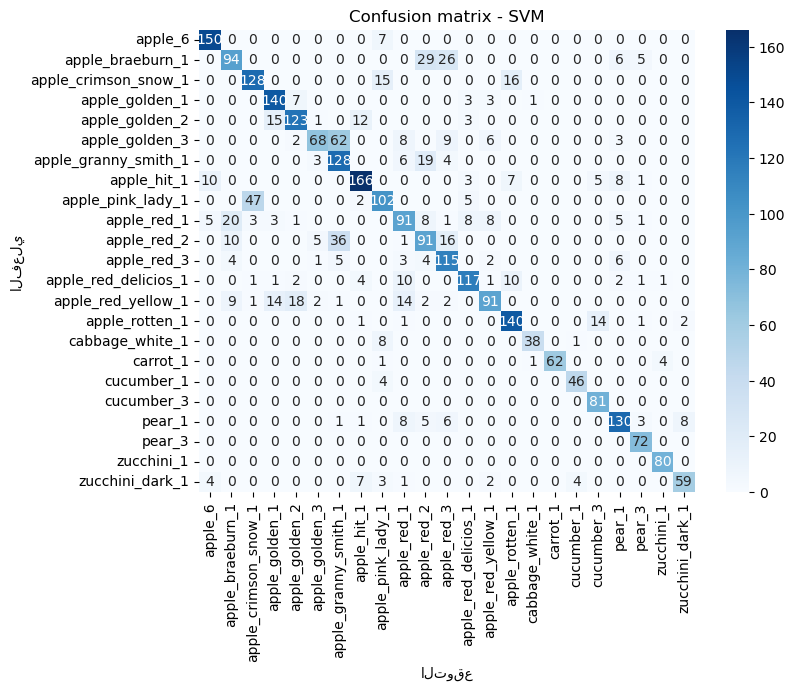


🚀 Model training KNN
✅ Precision using KNN: 87.76%


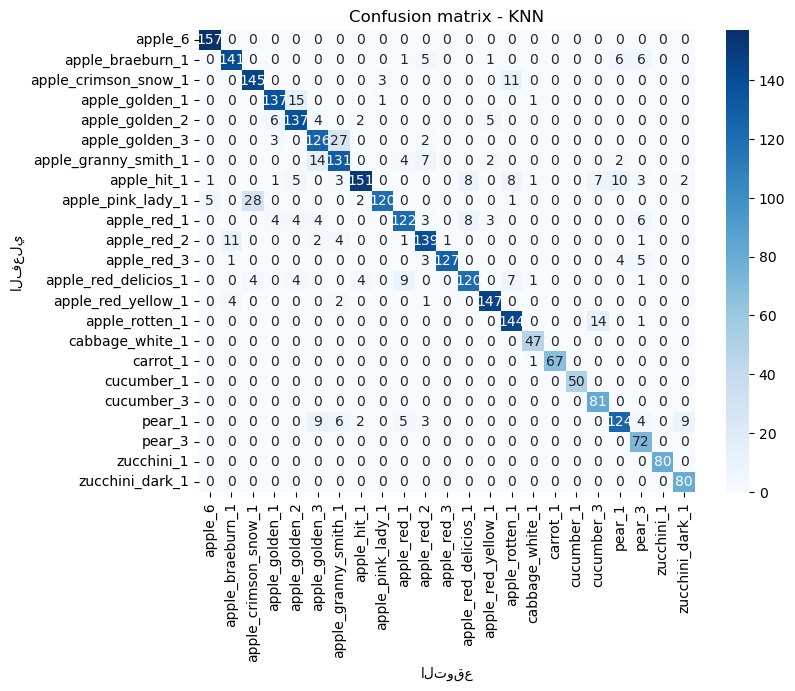


🚀 Model training MLP
✅ Precision using MLP: 89.85%


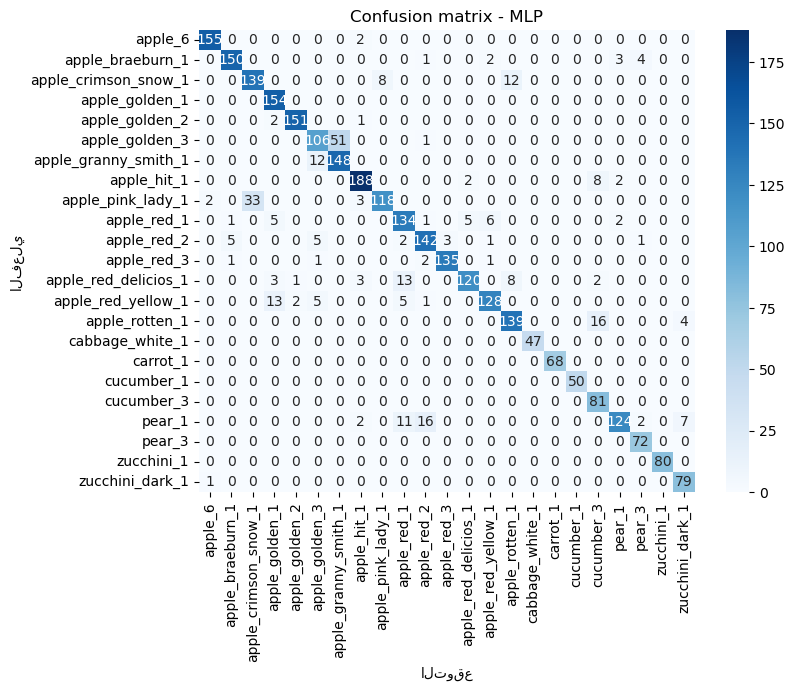

In [16]:
models = {
    "SVM": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

for name, model in models.items():
    print(f"\n🚀 Model training {name}")
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Precision using {name}: {acc * 100:.2f}%")

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion matrix - {name}")
    plt.xlabel("التوقع")
    plt.ylabel("الفعلي")
    plt.show()

##### Test a photos

In [18]:
import joblib

# Model training
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_selected, y_train)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_selected, y_train)

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_selected, y_train)

# حفظ النماذج
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(knn_model, 'knn_model.pkl')
joblib.dump(mlp_model, 'mlp_model.pkl')

print("Forms saved successfully ✅")


Forms saved successfully ✅


In [52]:
# تحميل النموذج المدرب مسبقًا
svm_model = joblib.load('mlp_model.pkl')  # يمكنك تحميل أي نموذج آخر بناءً على اختيارك
selected_indices = np.load("selected_indices.npy")  # تحميل الخصائص المختارة باستخدام APGWO

# تحديد أسماء الفئات (تأكد من ملاءمة هذه الأسماء للبيانات لديك)
class_names = ['apple_6', 'apple_braeburn_1', 'apple_crimson_snow_1', 'apple_golden_1',
               'apple_golden_2', 'apple_golden_3', 'apple_granny_smith_1', 'apple_hit_1', 'apple_pink_lady_1', 'apple_red_1', 'apple_red_2',
               'apple_red_3', 'apple_red_delicios_1', 'apple_red_yellow_1', 'apple_rotten_1', 'cabbage_white_1', 'carrot_1', 'cucumber_1',
               'cucumber_3', 'pear_1', 'pear_3', 'zucchini_1', 'zucchini_dark_1']  # عدّل حسب الفئات لديك

label_mapping = {
    'apple_6': 'Apple',
    'apple_braeburn_1': 'Apple',
    'apple_crimson_snow_1': 'Apple',
    'apple_golden_1': 'Apple',
    'apple_golden_2': 'Apple',
    'apple_golden_3': 'Apple',
    'apple_granny_smith_1': 'Apple',
    'apple_hit_1': 'Apple',
    'apple_pink_lady_1': 'Apple',
    'apple_red_1': 'Apple',
    'apple_red_2': 'Apple',
    'apple_red_3': 'Apple',
    'apple_red_delicios_1': 'Apple',
    'apple_red_yellow_1': 'Apple',
    'apple_rotten_1': 'Apple',
    'cabbage_white_1': 'Cabbage',
    'carrot_1': 'Carrot',
    'cucumber_1': 'Cucumber',
    'cucumber_3': 'Cucumber',
    'pear_1': 'Pear',
    'pear_3': 'Pear',
    'zucchini_1': 'Zucchini',
    'zucchini_dark_1': 'Zucchini'
}
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# تحميل النموذج الأساسي بدون الطبقات العليا
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)


def predict_image(img_path):
    # 1. Image processing
    img = load_img(img_path, target_size=(100, 100))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # 2. Feature extraction from DenseNet
    feature = feature_extractor.predict(img_array)  # (1, 1, 1, 1024)
    feature = feature.reshape((1, -1))  # تحويل إلى (1, 1024)

    # 3. Select specific properties from APGWO
    selected_features = feature[:, selected_indices]  # (1, N_selected)

    # 4. Prediction using the loaded classifier
    prediction = svm_model.predict(selected_features)  # اختر النموذج الذي تود استخدامه هنا
    predicted_class = class_names[prediction[0]]


     # 5. Use general label
    predicted_class = class_names[prediction[0]]
    general_class = label_mapping.get(predicted_class, predicted_class)
    print(f"Image belongs to: {general_class}")


# Test prediction on an image
image_path = r"C:\Users\Moham\Graduation Project\New\جزر-١.jpg"
predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Image belongs to: Carrot
